In [1]:
import numpy as np


def softmax(logits):
    """softmax function"""
    return np.exp(logits) / np.sum(np.exp(logits), keepdims=True)
def softmax_grad(s):
    jacobian_m = np.diag(s)
    for i in range(len(jacobian_m)):
        for j in range(len(jacobian_m)):
            if i == j:
                jacobian_m[i][j] = s[i] * (1-s[i])
            else:
                jacobian_m[i][j] = -s[i] * s[j]
    return jacobian_m
def policy(state, weight):
    """simple policy function"""
    # flatten the state with the weight
    logits = np.dot(state, weight)
    action_probs = softmax(logits)
    return action_probs

def policy_gradient(state, weight):
    """Compute policy gradient"""
    # Compute action probabilities using the policy
    action_probs = policy(state, weight)
    action = np.random.choice(len(action_probs), p=action_probs)

    grad_logits_wrt_weights = np.outer(state, softmax_grad(action_probs)[action])

    return action, grad_logits_wrt_weights


In [2]:
def xavier_init(shape):
    """Xavier initialization for weights"""
    fan_in = shape[0]
    fan_out = shape[1]
    stddev = np.sqrt(2.0 / (fan_in + fan_out))
    return np.random.normal(0, stddev, shape)
def he_init(shape):
    """He initialization for weights"""
    fan_in = shape[0]
    stddev = np.sqrt(2.0 / fan_in)
    return np.random.normal(0, stddev, shape)

In [11]:
import tqdm
import imageio
import IPython.display as display
import time
def train(env, nb_episodes, alpha=0.000045, gamma=0.98 , show_result = False):
    """training function"""
    # initialize the weight
    weight = he_init((env.observation_space.shape[0], env.action_space.n))

    scores = []
    for ep in tqdm.tqdm(range(nb_episodes)):
        state, _ = env.reset()
        episode = []
        grads = []
        episode_score = 0
        while True:
            action, grad = policy_gradient(state, weight)
            next_state, reward, done, _, _ = env.step(action)
            episode.append((state, action, reward))
            grads.append(grad)
            episode_score += reward

            state = next_state
            if done:
                break
        if show_result and (ep+1) % 1000 == 0:
            env.render()
            st ,_= env.reset()
            img = env.render()
            imgs = []
            while True:
                action, _ = policy_gradient(st, weight)
                state, reward, done, _, _ = env.step(action)
                img = env.render()
                imgs.append(img)
                if done:
                    break
            gif_path = f'gif/cartpole{ep+1}.gif'
            imageio.mimsave(gif_path, [np.array(img) for i, img in enumerate(imgs) ], fps=1000)
            display.display(display.Image(filename=gif_path))
            time.sleep(1.5)  # Display the GIF for 2 seconds
            display.clear_output(wait=True)  # Clear the output after displaying the GIF
            env.close()
        scores.append(episode_score)
        for i in range(len(episode)):
            Gt = sum([gamma**j * episode[j][2]
                     for j in range(i, len(episode))])
            step, action, _ = episode[i]
            action_probs = policy(step, weight)
            Ln = np.log(action_probs[action])
            weight += alpha * gamma**i * Gt * Ln * grads[i]
    return scores 

100%|██████████| 10000/10000 [00:26<00:00, 381.55it/s]


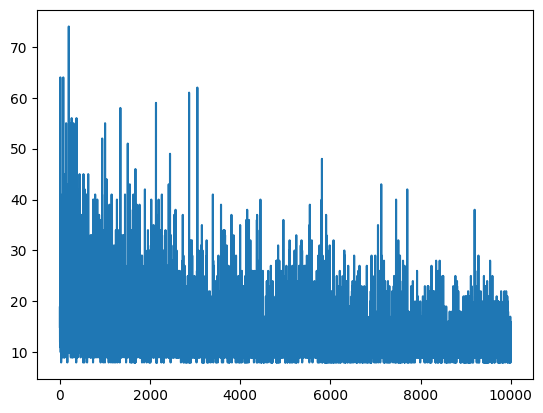

In [13]:
import gym
import matplotlib.pyplot as plt
import numpy as np

env = gym.make('CartPole-v1' , render_mode = 'rgb_array')
scores = None
scores  = train(env, nb_episodes=10000, show_result = True)


plt.plot(np.arange(len(scores)), scores)
plt.show()
env.close()

In [ ]:
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler

def objective(trial):
    # Get the hyperparameters
    alpha = trial.suggest_float('alpha', 1e-7, 1e-2)
    gamma = trial.suggest_float('gamma', 0.7, 0.99900)
    nb_episodes = trial.suggest_int('nb_episodes', 300, 10000)

    # Train the model
    env = gym.make('CartPole-v1')  # Create the environment
    weight, scores = train(env, nb_episodes, alpha, gamma)
    env.close()  # Close the environment after training
    return np.max(scores)

sampler = TPESampler()
pruner = MedianPruner(n_warmup_steps=5)
study = optuna.create_study(sampler=sampler, pruner=pruner)
study.optimize(objective, n_trials=100)

print("Best trial:")
best_trial = study.best_trial
print("  Value: ", best_trial.value)
print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

In [44]:
import gym
import imageio
env = gym.make('CartPole-v1' , render_mode = "rgb_array")  # Create the environment

# Render the environment
st ,_= env.reset()
action = 1
img = env.render()
images = []
print(weit.shape)
print(st.shape)
while True:
    action = np.argmax(policy(st, weit))
    st, reward, done, _ ,_= env.step(action)
    img = env.render()
    images.append(img)
    if done:
        break
imageio.mimsave('cartpole.gif', [np.array(img) for i, img in enumerate(images) ], fps=1000)


env.close()  # Close the environment after rendering


(4, 2)
(4,)
32
